In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import sys
import xbmodeling as xb
import xbmodeling.gen_model as gm
from xbmodeling.config import modelconf
import xbmodeling.pointing_model as pnt
from xbmodeling.config import mountconf

## Physical Model
The goal of our generative model is to simulate "pair-difference" timestreams between two detectors on a telescope as is scans across the sky. By design, the detectors point at the same location on the sky and are orthongonally sensitive to polarization. Below describes the physical motivations of the model.

### Detector timestreams

Total response of a single detector is the combination of the detectors response to the sky intensity $d_T$ and polarization $d_P$ scaled by some gain factor $g$.

$$d = g\left(d_T+d_P\right)$$

$d_T$ is the true signal of the sky intensity $T(\theta,\phi)$ convolved with the spatial response, or beam, of the detector $B_T(\theta,\phi)$

$$d_T = \int T(\theta,\phi) B_T(\theta,\phi) d\Omega$$

which we'll henceforth write in shorthand as

$$d_T = T \ast B_T$$

The detector and sky also have a polarization element which we represent in Stokes Q/U:


$$d_Q = Q \ast B_Q \cos(2\psi)+ Q \ast B_U \sin(2\psi) $$

$$d_U = U \ast B_Q \sin(2\psi)+ U \ast B_U \cos(2\psi) $$

and the combined signal is

$$d_P = \kappa\left[d_Q + d_U\right] $$

where where $\kappa$ is the detector cross-polarization efficiency, which can be thought of as a measure of the sensitivity of the detector to polarization.


To simplify things, we can define our instrument axes such that $\int B_U = 0$ and we have a single polarization beam, $B_P$. 

$$d_P = \kappa\left[Q \ast B_P \cos(2\psi)+ U \ast B_P \sin(2\psi)\right] $$

Then the detector response becomes

$$d = g\left( B_T\ast T + \kappa\left[B_P \ast Q \cos(2\psi)  + B_P \ast U \sin(2\psi)\right]\right)$$

We then make assumptions to simplify things further. First, we assume the the intensity and polarization beams are of the same shape. We can also assume that the detector is an ideal polarimeter (i.e. $\kappa=1$).

$$d = g\left( B\ast T + B \ast Q \cos(2\psi)  + B \ast U \sin(2\psi)\right)$$

And since convolutions are associative, this can be written as one convolution instead of three:

$$d = g (B \ast \left[T+ Q \cos(2\psi) + U \sin(2\psi)\right])$$

### Pair Differencing 

In order to separate temperature from polarization, polarimeters have two detectors which are co-located on-sky ($B_A=B_B$) and orthonally oriented ($\psi_B =\psi_A+\pi/2$) so that, ideally, when their responses are added polarization cancels:

\begin{equation}
\begin{split}
d_A+d_B & = B_A \ast \left[T+ Q \cos(2\psi_A)  + U \sin(2\psi_A)\right]+B_B \ast \left[T+ Q \cos(2\psi_B)  + U \sin(2\psi_B)\right] \\
& = B_A \ast \left[T+ Q \cos(2\psi_A) + U \sin(2\psi_A)\right]+B_A \ast \left[T+ Q \cos(2(\psi_A+\pi/2))  + U \sin(2(\psi_A+\pi/2))\right] \\
& = B_A \ast \left[\left( T+ Q \cos(2\psi_A) + U \sin(2\psi_A)\right)+\left(T- Q \cos(2\psi_A) - U \sin(2\psi_A)\right)\right]\\
& = B_A \ast 2T\\
\end{split}
\end{equation}

Likewise, when differenced, only the polarization remains

\begin{equation}
\begin{split}
d_A-d_B & = B_A \ast \left[T+ Q \cos(2\psi_A)  + U \sin(2\psi_A)\right]-B_B \ast \left[T+ Q \cos(2\psi_B)  + U \sin(2\psi_B)\right] \\
& = B_A \ast \left[T+ Q \cos(2\psi_A) + U \sin(2\psi_A)\right]-B_A \ast \left[T+ Q \cos(2(\psi_A+\pi/2))  + U \sin(2(\psi_A+\pi/2))\right] \\
& = B_A \ast \left[\left( T+ Q \cos(2\psi_A) + U \sin(2\psi_A)\right)-\left(T- Q \cos(2\psi_A) - U \sin(2\psi_A)\right)\right]\\
& = B_A \ast 2\left[Q \cos(2\psi_A) + U \sin(2\psi_A)\right]\\
\end{split}
\end{equation}

However, we know emperically that the contamination in our signal due to dissimilarity in our beams is significant so in our model, we can't assume $B_A=B_B$. In contrast, the contamination from assuming our detectors are perfectly orthogonal has been found to be insignificant, so we can still assume $\psi_B =\psi_A+\pi/2$. It follows then that the "polarization only" response we get from pair-differencing actually has some non-zero contamination from the temperature signal.

$$d_A-d_B = \left[B_A-B_B\right]\ast T + \left[B_A+B_B\right]\ast \left[Q\cos(2\psi_A)+U\sin(2\psi_A)\right]$$

In the code, we want to minimize the number of convolutions computed per model generation. In application, the on-sky detector polarization angle $\psi$ is the parallactic angle between the detector polarization axis and zenith which is continuously changing as the telescope scans across the sky. It wouldn't make sense to do convolutions for every data point, so we manipulate the equation above to bring the number of convolutions down to three. One for each T, Q, and U map:

$$d_A-d_B = \left[B_A-B_B\right]\ast T + \left[B_A+B_B\right]\ast Q\cos(2\psi_A)+\left[B_A+B_B\right]\ast U\sin(2\psi_A)$$

Which is the final form our generative model takes. For some input beam parameters and timestreams of telescope pointing, the model will output a timestream of the pair-difference of two co-located orthogonally oriented detectors.

### Generative Model Code

The module `gen_model` is responsible for taking telescope scans and ultimately returning simulations of per-pixel timestreams. It loads the CMB maps, generates background and beam maps, and handles the convolution and reobservation of these maps. All of this functionality is packed into the `GenModelMap` Class, which we'll discuss in a bit. Some examples on how the map-making subfunctions are used is below:

/n/home08/jcornelison/.conda/envs/phy201/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Current map NSIDE=512. Converting to NSIDE=128



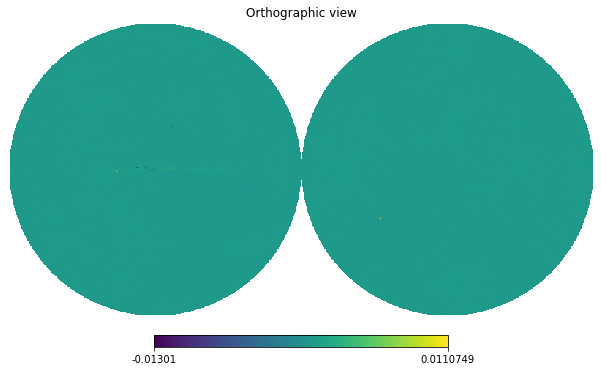

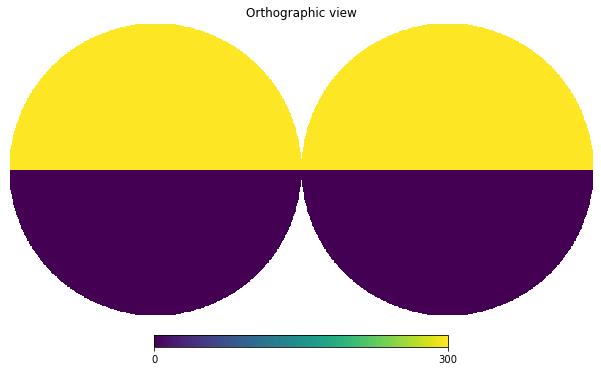

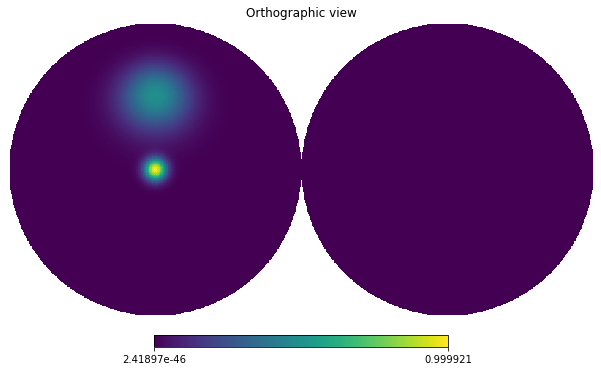

In [2]:
# Example usage of the gen_model subfunctions:
# Extract some CMB map. Lower the resolution so that it doesn't take forever
nside = 128
cmbmap = gm.make_cmb_map(modelconf["cmbFile"], nside_out=nside)

## Make a background map of 300K
groundmap = gm.make_ground_template(300,nside)

## Make a beammap made of a main beam and an 'extended' beam.
beammap = gm.make_beam_map(params = [1,0,0,3,3,0],nside=nside)
beammap2 = gm.make_beam_map(params =[0.5,30,0,10,10,0],nside=nside)
bm_total = (beammap+beammap2)/np.max(beammap+beammap2) # Add and normalize

# Plot the different maps
hp.orthview(cmbmap[0,:])
hp.orthview(groundmap)
R = hp.Rotator([0,-90]).rotate_map_pixel
hp.orthview(R(bm_total))

print()

### Pointing Model
The other important module is called `pointing_model`. Given from telescope pointing information from the data and telescope focal plane information, this will tell us the _apparent_ pointing for a given detector. This also handles per-detector polarization orientations. The module is built to take `pandas` dataframs which contain detector and telescope pointing information.

Lastly, telescope information is built into the configuration file `config.py` under the `mountconf` dictionary. Currently, only Keck and BICEP3 are included.

In [3]:
# Load some test data
tod_full, scans, det_info = xb.io.load_tod_file("xbmodeling/input_data/bicepkeck_tods/20150531C01_dk068_tod_singlepair.mat")


%time tod_pointing = pnt.beam_pointing_model(tod_full, det_info)
display(tod_pointing)

CPU times: user 2.44 s, sys: 16.2 ms, total: 2.46 s
Wall time: 2.73 s


,time_utc,A_sig,B_sig,tel_hor_az,tel_hor_el,tel_hor_dk,tel_cel_ra,tel_cel_dec,tel_cel_dk,app_ra_0,app_dec_0,pa_0,app_ra_1,app_dec_1,pa_1
0,57174.037606,-4215.054678,-1710.644564,97.697229,57.589618,-292.060002,315.477374,-57.657934,-472.188946,181.602339,-61.555055,107.906673,181.602339,-61.555055,107.906673
1,57174.037607,-4215.149687,-1714.786194,97.697228,57.589618,-292.059974,315.477582,-57.657934,-472.188914,181.602550,-61.555052,107.906704,181.602550,-61.555052,107.906704
2,57174.037607,-4217.558236,-1717.665712,97.697232,57.589618,-292.059960,315.477796,-57.657934,-472.188899,181.602765,-61.555051,107.906720,181.602765,-61.555051,107.906720
3,57174.037608,-4218.191274,-1715.694944,97.697289,57.589618,-292.059953,315.478063,-57.657935,-472.188896,181.603033,-61.555050,107.906728,181.603033,-61.555050,107.906728
4,57174.037609,-4215.781317,-1716.254638,97.697348,57.589618,-292.059960,315.478331,-57.657935,-472.188899,181.603299,-61.555051,107.906720,181.603299,-61.555051,107.906720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76815,57174.072244,-4237.716167,-1736.832790,97.696318,57.589617,-292.060029,328.006013,-57.669375,-472.158989,194.105043,-61.555055,107.906643,194.105043,-61.555055,107.906643
76816,57174.072244,-4237.891372,-1736.949323,97.696281,57.589617,-292.060022,328.006186,-57.669375,-472.158976,194.105216,-61.555055,107.906651,194.105216,-61.555055,107.906651
76817,57174.072245,-4236.625530,-1734.859628,97.696289,57.589517,-292.060000,328.006432,-57.669276,-472.158955,194.105432,-61.554954,107.906637,194.105432,-61.554954,107.906637
76818,57174.072245,-4233.841163,-1735.926362,97.696298,57.589517,-292.060014,328.006621,-57.669276,-472.158967,194.105618,-61.554956,107.906621,194.105618,-61.554956,107.906621


### The GenModelMap class function:
```
GenModelMap(cmb_file=modelconf["cmbFile"],
   T=modelconf["groundTemperature"],
   nside=modelconf["defaultResolution"],
   main_beam_params_A=None,
   main_beam_params_B=None, 
   ext_beam_params=None
   )
```
This class holds and handles all of the model information (i.e. CMB, beammaps, etc.) which are informed by various inputs such a the detector pointing. 

In [4]:
nside=64
# Truncate the data so this doesn't take forever
tod_in = xb.io.keep_scans(tod_full,scans,np.arange(20))

model = gm.GenModelMap(tod_in, det_info, nside=nside)

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/n/home08/jcornelison/.conda/envs/phy201/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


Current map NSIDE=512. Converting to NSIDE=64


Uninitialized, the class produces a delta function for the beammap so that the convolution map will simply be the CMB+background map.

It also has the ability to plot the maps is holds:

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


/n/home08/jcornelison/.conda/envs/phy201/lib/python3.8/site-packages/healpy/projaxes.py:423: RuntimeWarning: invalid value encountered in greater
  w = np.where(d2 > threshold)[0]


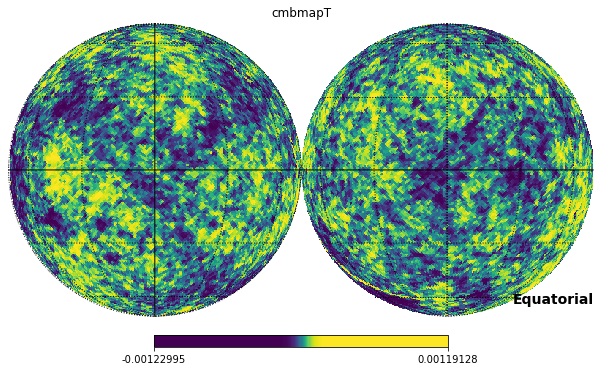

In [5]:
model.mapplot('cmbmapT')
#model.mapplot('groundmap',min=0,max=300)
#model.mapplot('all')

For parameter estimation, instead of making a new instance of the model and having to load and create all of the maps again, we can tell the model to regenerate only the parts we want to change. For instance, if we want to change the beam width of the extended beam, only the extended beam map is reproduced:

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.
CPU times: user 1.01 s, sys: 5.52 ms, total: 1.01 s
Wall time: 1.53 s
0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


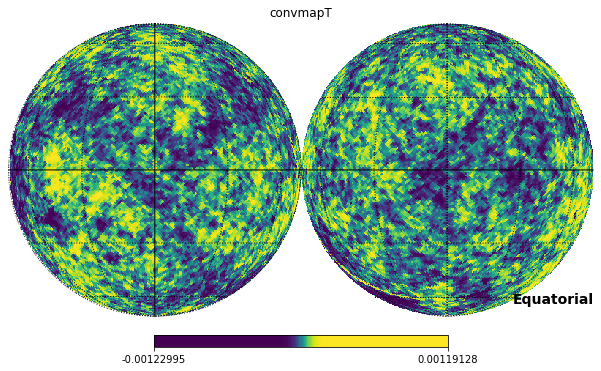

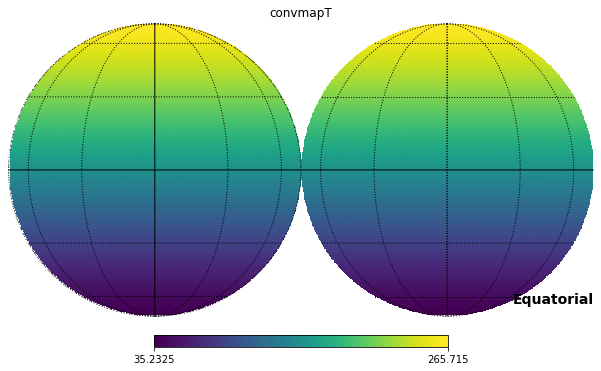

In [7]:
model.regen_model(extended=[1,30,0,1,1,0])
model.mapplot('convmapT') # Look at the T-to-P leakage map

# Change up some more parameters
%time model.regen_model(mainA=[1,0,0,1,1,0],\
                        mainB=[1,5,0,1,1,0],\
                        extended=[0.1,30,0,30,30,0])
model.mapplot('convmapT')



Combined with the pointing model, we can extract timestreams for a detector by telling the model to observe the maps. The resulting pair-diff timestream is called `simdata` and is added to the input datafile and returned by `observe`

CPU times: user 4.05 ms, sys: 935 µs, total: 4.99 ms
Wall time: 13.2 ms



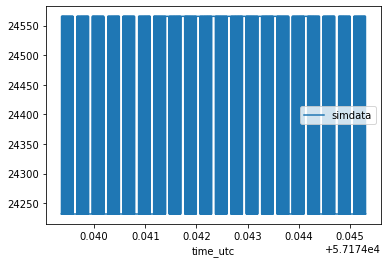

In [9]:
# Make an observation
%time tod_out = model.observe(mainA=[1,0,0,1,1,0],\
                             mainB=[1,5,0,1,1,0],\
                             extended=[0.1,30,0,30,30,0],extendedopt="buddy")
# Plot the data
tod_out.plot(x='time_utc',y='simdata')
print()

For troubleshooting, we can look at where the observation was:

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


/n/home08/jcornelison/.conda/envs/phy201/lib/python3.8/site-packages/healpy/projaxes.py:423: RuntimeWarning: invalid value encountered in greater
  w = np.where(d2 > threshold)[0]


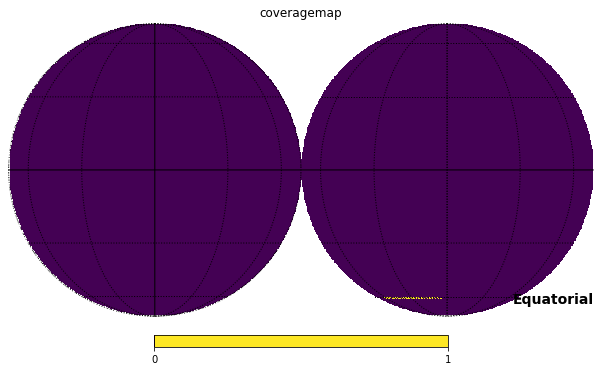

In [10]:
model.mapplot("coveragemap")